# Visual Model Evaluation

Being able to evaluate models numerically is really important for optimisation tasks. However, performing a visual evaluation provides two main benefits:

- Easier to spot mistakes
- Easier to explain to other people

In this workshop we will develop the code required to make:

- Profit curves
- ROC curves
- AUC
- Cumilative response curve
- Lift curve



In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt

## Generate data

First we will generate some data to work with.

This data simulates the marketing example, but you could easily imagine this being any type of data.

The key is that in order to generate any of these cuves, we need the raw scores for the classifier (for example probabilities of belonging to each class). Not the predicted classes.

In [2]:
np.random.seed(42)

y_proba = [0] * 100
y_proba[:20] = [1] * 10 - np.abs(np.random.randn(10)*0.3)
y_proba[20:60] = np.abs(np.random.randn(10)*0.1)
y_proba[60:] = [0] * 40 + np.random.uniform(0,1,40)

y_test = [1] * 20 + [0] * 80
print("Example data:\n", y_proba[:10], "...")
profit = 50
cost   = -9
cost_benefit = np.array([[profit+cost, cost],[0   , 0]])
print("Cost Benefit:\n", cost_benefit)

Example data:
 [0.85098575409663024, 0.95852070964864455, 0.80569343856979225, 0.54309104307759237, 0.92975398758299921, 0.92975891291524582, 0.52623615534778256, 0.76976958125412742, 0.85915768421951433, 0.83723198692421064] ...
Cost Benefit:
 [[41 -9]
 [ 0  0]]


Remember that the sklearn confusion matrix orders the output. So let's take some time to investigate the ordering and map that output to what we expect.

In [3]:
tmp_y_pred = [0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
tmp_y_test = [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
metrics.confusion_matrix(tmp_y_test, tmp_y_pred)

array([[4, 1],
       [2, 3]])

The results should be three TP, four TN, two FP and one FN:

|  |P |N |
|--|--|--|
|y |3 | 1|
|n |2 | 4|

So let's write a method that maps to this.

In [4]:
def lit_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

print(lit_confusion_matrix(tmp_y_test, tmp_y_pred))

[[3 1]
 [2 4]]


## Ranking

The next step is to rank the results by a threshold. The procedure is:

- Generate a threshold
- Threshold the scores
- Turn the scores into a confusion matrix
- Calculate the profit

In [5]:
profits = []
for T in sorted(y_proba, reverse=True):
    y_pred = (y_proba > np.array(T)).astype(int)
    confusion_mat = lit_confusion_matrix(y_test, y_pred)
    # Calculate total profit for this threshold
    profit = sum(sum(confusion_mat * cost_benefit)) / len(y_test)
    profits.append(profit)

## Profit Curve

Let's plot that data!

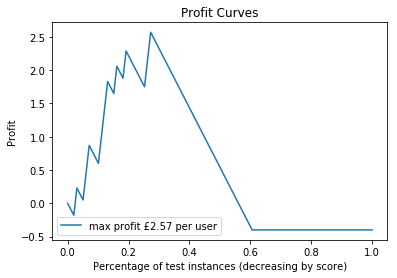

In [6]:
# Profit curve plot
max_profit = max(profits)
plt.figure();
plt.plot(np.linspace(0, 1, len(y_test)), profits, label = 'max profit Â£{} per user'.format(max_profit))

# Plot labels
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.show()

Nice work!

So, the jaggedness is because we've used dummy data and not many datapoints. But use a little artistic license and you can start to see a real profit curve. We can see in this data we make the most profit by including about 25% of the data.

## ROC Curve

The receiver operating curve plots the false positive rate against the true positive rate, whilst iterating over the thresholds again.

This is similar to the profit curve except that it doesn't take profit into considertaion. It is purely a measure of how well the classifier is performing

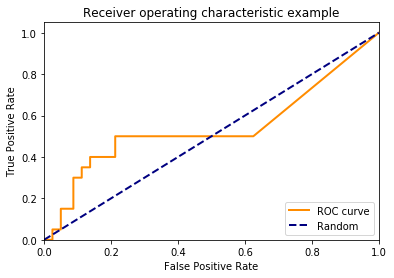

In [7]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

plt.figure();
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This classifier isn't doing much better than randomly picking a class!

## AUC

We can also calculate the AUC for this curve. The AUC is a robust measure of classifier performance.

In [8]:
print("AUC: ", metrics.auc(fpr, tpr))

AUC:  0.540625


## Cumulative Response

Remember that the the ROC curve, despite describing a full picture of classifier performance, is not very intuitive.

We can change the x-axis to represent the proportion of included samples.

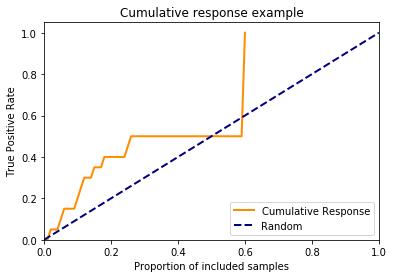

In [9]:
_, tpr, thresholds = metrics.roc_curve(y_test, y_proba)

prop_included = []
for T in thresholds:
    y_pred = (y_proba > np.array(T)).astype(int)
    prop_included.append(sum(y_pred)/ len(y_test))
    
plt.figure()
lw = 2
plt.plot(prop_included, tpr, color='darkorange',
         lw=lw, label='Cumulative Response')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportion of included samples')
plt.ylabel('True Positive Rate')
plt.title('Cumulative response example')
plt.legend(loc="lower right")
plt.show()

## Lift curve

The lift curve is simply the cumulative response divided by the random chance line (i.e. `y-axis = tpr / prop_included`)

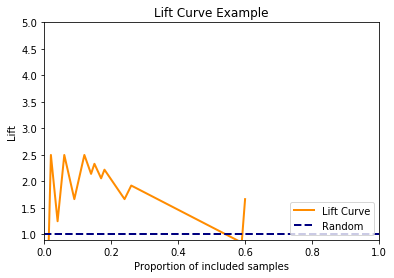

In [10]:
fig = plt.figure()
lw = 2
# Add a bit of funky-ness to avoid divide by zero errors.
plt.plot(prop_included, np.divide(tpr, prop_included, out=np.zeros_like(tpr), where=np.array(prop_included)!=0), 
         color='darkorange', lw=lw, label='Lift Curve')
plt.plot([0, 1], [1, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.9, 5])
plt.xlabel('Proportion of included samples')
plt.ylabel('Lift')
plt.title('Lift Curve Example')
plt.legend(loc="lower right")
plt.show()

In [11]:
np.random.seed(42)

y_proba = [0] * 1000
y_proba[:200] = [1] * 100 - np.abs(np.random.randn(100)*0.3)
y_proba[200:600] = np.abs(np.random.randn(100)*0.1)
y_proba[600:] = [0] * 400 + np.random.uniform(0,1,400)

y_test = [1] * 400 + [0] * 600

## Tasks

- Plot the ROC curve for the data above
- Plot the cumulative response curve for the data above